# Model Stuff

In [1]:
# from ipynb.fs.full.functions import *
from ipynb.fs.full.functions_stream_env import *
import spacy

In [2]:
# Data to create our model
dfa = pd.read_csv('../data/ama_comments.csv')
dfb = pd.read_csv('../data/ar_comments.csv')
df = pd.concat([dfa, dfb], axis=0)
df = CleanUp(df).df.copy()

In [3]:
# Model X, and y
df = df.sample(n=df.shape[0], random_state=3)

X = df['body']
y = df['subreddit_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [5]:
# TEST data (not part of train/test/split)
df1 = pd.read_csv('../data/2021-04-27_1812_AMA_comments.csv')
df2 = pd.read_csv('../data/2021-04-27_1812_AskReddit_comments.csv')
df_test_pred = pd.concat([df1, df2], axis=0)
df_test_pred = CleanUp(df_test_pred).df.copy()

In [6]:
df_test_pred = df_test_pred.sample(n=df_test_pred.shape[0], random_state=3)

X_new = df_test_pred['body']
y_new = df_test_pred['subreddit_binary'] 

<h2 style="color:black;"> (gridsearch) TfidfVectorizer(), LogisiticRegression() </h2>

#### BEST Params:
 - max_features: 
 - ngram_range: 
 - stop_words: 

In [7]:

gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf LogReg')



In [8]:

X_gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train=X, X_test=X_new, y_train=y, y_test=y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf LogReg')



<h2> (gridsearch) TfidfVectorizer(), MultinomialNB() </h2>


In [9]:
gs_tv_nb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    MultinomialNB()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf nBayes')



In [10]:
X_gs_tv_nb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    MultinomialNB()), 
    X, X_new, y, y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf nBayes')


### MAKE MODEL FUNCTION(S)

In [11]:
from sklearn.ensemble import VotingClassifier

### GridSearch Voting Ensemble
## Logistic Regression + Naive Bayes

In [12]:
vote_lgr_gsbayes = VotingClassifier(
    [('gs_nb', gs_tv_nb.model), 
     ('lgr', gs_tv_lgr.model)],
    weights=[ 0.4, 0.6 ]
)

In [13]:
vote_lgr_gsbayes.fit_transform(X_train, y_train)

array([[0, 0],
       [0, 0],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [1, 1]], dtype=int64)

In [14]:
y_pred_lgr_gsbayes = vote_lgr_gsbayes.predict(X_test)

f1_score(y_test, y_pred_lgr_gsbayes)

0.7275603005140372

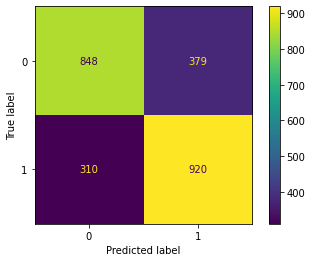

In [15]:
plot_confusion_matrix(vote_lgr_gsbayes, X_test, y_test)

In [16]:
vote_X_lgr_gsbayes = VotingClassifier(
    [('gs_nb', X_gs_tv_nb.model), 
     ('lgr', X_gs_tv_lgr.model)],
    weights=[ 0.4, 0.6 ]
)

In [17]:
vote_X_lgr_gsbayes.fit_transform(X, y)

array([[0, 1],
       [1, 1],
       [0, 1],
       ...,
       [1, 1],
       [0, 0],
       [1, 1]], dtype=int64)

In [18]:
y_new_pred_lgr_gsbayes = vote_X_lgr_gsbayes.predict(X_new)

f1_score(y_new, y_new_pred_lgr_gsbayes)

0.6696078431372549

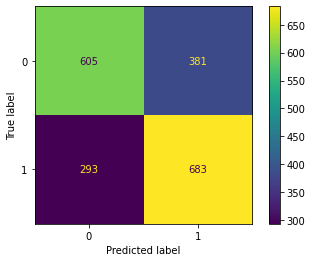

In [19]:
plot_confusion_matrix(vote_X_lgr_gsbayes, X_new, y_new)

In [33]:
print_classification_stats(y_new, y_new_pred_lgr_gsbayes)

{'F1 Score': 0.6696078431372549,
 'Recall Score': 0.6997950819672131,
 'Accuracy Score': 0.6564729867482161,
 'Balanced Accuracy': 0.6566926728294483,
 'Precision Score': 0.6419172932330827,
 'True Positive': 683,
 'False Negative': 293,
 'False Positive': 381,
 'True Negative': 605,
 'Calculated Accuracy': 0.6564729867482161,
 'Calculated Precision': 0.6419172932330827,
 'Calculated Sensitivity': 0.6997950819672131,
 'Calculated Specificity': 0.6135902636916836}

In [34]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(y_new, y_new_pred_lgr_gsbayes))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       986
           1       0.64      0.70      0.67       976

    accuracy                           0.66      1962
   macro avg       0.66      0.66      0.66      1962
weighted avg       0.66      0.66      0.66      1962

